# Data Vault Demo (Dev -- Full Access)

The basic concept of the Data Vault is that when a user authenticates themself, they receive an engine that gives them access to all the data (rows, columns, tables, schema, etc.) for which they are authorized.  Users who can authenticate themselves for multiple roles can use those roles simultaneously.  We are keeping in mind the importance of Data Lineage Management (tracked by issue https://github.com/os-climate/os_c_data_commons/issues/50) but is not treated as part of this particular prototype.

The steps of this demo are:

1. **Authenticate and acquire SQLAlchemy engine**
    1. **Dev engine sees all**
    2. Quant engine can do temp scoring but not see fundamental company info
    3. User engine can use temp scoring but not see cumulative emissions nor overshoot info
2. **With Dev engine, construct Vaults for:**
    1. **Fundamental corporate financial information**
    2. **Corporate emissions data (base year, historical)**
    3. **Corporate target data (start year, end year, target start value, target end value)**
    4. **Sector benchmark data (production, CO2e intensity)**
3. **Dev Engine: Visualize projected emissions (targets and trajectories) and calculate cumulative emissions**
4. Quant Engine: Using calculated cumulative emmisions, visualize per-company trajectory and target temperature scores
5. User Engine: Using consensus probability scoring and own portfolio data (ISIN, position value)
    1. Calculate publishable per-company temperature alignment score
    2. Based on aggregate corporate and portfolio information, produce weighting scores to yield overall portfolio alignment score

In [1]:
import os
import pathlib
from dotenv import load_dotenv
import osc_ingest_trino as osc
import trino
from sqlalchemy.engine import create_engine

import json
import pandas as pd
import numpy as np
from numpy.testing import assert_array_equal
import ITR

# from ITR.portfolio_aggregation import PortfolioAggregationMethod
# from ITR.temperature_score import TemperatureScore
# from ITR.configs import ColumnsConfig, TemperatureScoreConfig
# from ITR.data.data_warehouse import DataWarehouse
from ITR.data.vault_providers import VaultCompanyDataProvider, VaultProviderProductionBenchmark, \
    VaultProviderIntensityBenchmark, DataVaultWarehouse, requantify_df

# from ITR.interfaces import ICompanyData, EScope, ETimeFrames, PortfolioCompany, IEIBenchmarkScopes, \
#     IProductionBenchmarkScopes
from ITR.interfaces import EScope, IProductionBenchmarkScopes, IEIBenchmarkScopes

from ITR.data.osc_units import ureg, Q_, PA_

from pint_pandas import PintArray

/opt/app-root/lib64/python3.8/site-packages/openscm_units/_unit_registry.py:471: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for label, val in metric_conversion.iteritems():


using connect string: trino://MichaelTiemannOSC@trino-secure-odh-trino.apps.odh-cl2.apps.os-climate.org:443/osc_datacommons_dev/demo_dv


In [2]:
# Load some standard environment variables from a dot-env file, if it exists.
# If no such file can be found, does not fail, and so allows these environment vars to
# be populated in some other way
dotenv_dir = os.environ.get('CREDENTIAL_DOTENV_DIR', os.environ.get('PWD', '/opt/app-root/src'))
dotenv_path = pathlib.Path(dotenv_dir) / 'credentials.env'
if os.path.exists(dotenv_path):
    load_dotenv(dotenv_path=dotenv_path,override=True)

### Step 1: Initialize Vault user 'Dev', which has full visibility into corporate financial, production, and target data

In [3]:
sqlstring = 'trino://{user}@{host}:{port}/'.format(
    user = os.environ['TRINO_USER_USER1'], # user = os.environ['TRINO_USER'],
    host = os.environ['TRINO_HOST'],
    port = os.environ['TRINO_PORT']
)

ingest_catalog = 'osc_datacommons_dev'
ingest_schema = 'demo_dv'
itr_prefix = 'itr_'

sqlargs = {
    'auth': trino.auth.JWTAuthentication(os.environ['TRINO_PASSWD_USER1']),
    'http_scheme': 'https',
    'catalog': ingest_catalog,
    'schema': ingest_schema,
}

engine_dev = create_engine(sqlstring, connect_args = sqlargs)
print("connecting with engine " + str(engine_dev))
qres = osc._do_sql(f"show tables in {ingest_schema}", engine_dev, verbose=True)

# Check that we have the tables we need
required_tables = ['company_data', 'target_data', 'trajectory_data', 'emissions_data', 'benchmark_prod', 'benchmark_ei']
existing_tables = [ q[0] for q in qres ]
missing_tables = [ rtable for rtable in required_tables if f"{itr_prefix}{rtable}" not in existing_tables ]
if missing_tables:
    print(f"Missing tables (itr_prefix = {itr_prefix}): {missing_tables}")
    assert False

connecting with engine Engine(trino://os-climate-user1@trino-secure-odh-trino.apps.odh-cl2.apps.os-climate.org:443/)
show tables in demo_dv
[('itr_benchmark_ei',), ('itr_benchmark_prod',), ('itr_company_data',), ('itr_cumulative_emissions',), ('itr_emissions_data',), ('itr_overshoot_ratios',), ('itr_production_data',), ('itr_target_data',), ('itr_temperature_scores',), ('itr_trajectory_data',)]


### The ITR module provides Vault objects that coordinate the interaction of Dev, Quant, and User roles.

The SQLAlchemy engines mediate the actual interaction with the Data Vault.

### Step 2: construct vaults for corporate financial, production, and target information.

We also create benchmark data (which is presumed public information).  There's more work to be done to modularly add new benchmarks that automatically become available options to to the ITR tool.

In this demo we read ITR benchmark data from JSON files (REST API-friendly).  Such data coming from the notebook filesystem is "untethered" data.  The corporate data comes from an existing data pipeline (in this case, the pipeline processing RMI data).  When data comes from the data commons, it is "tethered" to the Data Commons.  The Data Vault can only control access to data that goes through the Data Commons via 'engines'.

In [4]:
root = root = os.path.dirname(os.getcwd())
benchmark_prod_json = os.path.join(root, "examples/data", "json-units", "benchmark_production_OECM.json")
benchmark_EI_json = os.path.join(root, "examples/data", "json-units", "benchmark_EI_OECM_S3.json")

# load production benchmarks
with open(benchmark_prod_json) as json_file:
    parsed_json = json.load(json_file)
prod_bms = IProductionBenchmarkScopes.parse_obj(parsed_json)
vault_production_bm = VaultProviderProductionBenchmark(engine=engine_dev, benchmark_name=f"{itr_prefix}benchmark_prod", production_benchmarks=prod_bms)

# load intensity benchmarks
with open(benchmark_EI_json) as json_file:
    parsed_json = json.load(json_file)
ei_bms = IEIBenchmarkScopes.parse_obj(parsed_json)
vault_EI_bm = VaultProviderIntensityBenchmark(engine=engine_dev, benchmark_name=f"{itr_prefix}benchmark_ei", EI_benchmarks=ei_bms)

# load company data
# TODO: Pandas reads null data mixed with integers as float64 (np.nan).  This can be fixed post hoc with astype('Int16')
vault_company_data = VaultCompanyDataProvider(engine=engine_dev, company_table=f"{itr_prefix}company_data")

vault_warehouse = DataVaultWarehouse(engine_dev, vault_company_data, vault_production_bm, vault_EI_bm, itr_prefix=itr_prefix)

year           Int64
production    object
region        string
sector        string
scope         string
dtype: object
Index(['year', 'production', 'region', 'sector', 'scope'], dtype='object')
RangeIndex(start=0, stop=2112, step=1)
constructed fully qualified table name as: "demo_dv.itr_benchmark_prod"
inserting 2112 records
  (2019, 0.0, 'dimensionless', 'Global', 'Steel', 'AnyScope')
  (2020, 0.00306, 'dimensionless', 'Global', 'Steel', 'AnyScope')
  (2021, 0.00306, 'dimensionless', 'Global', 'Steel', 'AnyScope')
  ...
  (2050, 0.019, 'dimensionless', 'North America', 'Textiles', 'AnyScope')
batch insert result: [(2112,)]
year               Int64
intensity         object
region            string
sector            string
scope             string
global_budget     object
benchmark_temp    object
dtype: object
Index(['year', 'intensity', 'region', 'sector', 'scope', 'global_budget',
       'benchmark_temp'],
      dtype='object')
RangeIndex(start=0, stop=9984, step=1)
constructed fully

### Step 3: Visualize Emissions, Targets, and Trajectories

SuperSet Dashboard here (not really, not yet, but points to TRINO_USER dashboard, not TRINO_USER1 dashboard): https://superset-secure-odh-superset.apps.odh-cl2.apps.os-climate.org/superset/dashboard/4/?edit=true&native_filters=%28%29

Plot emissions data.  Others can be plotted by following same pattern.

Note that without units, a company that emits 80 t CO2e/t Steel looks like it might emit a lot more than one that emits 10t CO2e/MWh.  With units, it becomes clear that the 80 and the 10 are not comparable.

In [5]:
sql_df = pd.read_sql_table(f"{itr_prefix}emissions_data", engine_dev)
sql_df

/opt/app-root/lib64/python3.8/site-packages/pandas/io/sql.py:1770: SAWarning: index key 'partition' was not located in columns for table 'itr_emissions_data'
  tbl = Table(
/opt/app-root/lib64/python3.8/site-packages/pandas/io/sql.py:1770: SAWarning: index key 'record_count' was not located in columns for table 'itr_emissions_data'
  tbl = Table(
/opt/app-root/lib64/python3.8/site-packages/pandas/io/sql.py:1770: SAWarning: index key 'file_count' was not located in columns for table 'itr_emissions_data'
  tbl = Table(
/opt/app-root/lib64/python3.8/site-packages/pandas/io/sql.py:1770: SAWarning: index key 'total_size' was not located in columns for table 'itr_emissions_data'
  tbl = Table(
/opt/app-root/lib64/python3.8/site-packages/pandas/io/sql.py:1770: SAWarning: index key 'data' was not located in columns for table 'itr_emissions_data'
  tbl = Table(


,company_name,company_lei,company_id,sector,year,co2_s1_by_year,co2_s1_by_year_units,co2_s2_by_year,co2_s2_by_year_units,co2_s3_by_year,co2_s3_by_year_units
0,Otter Tail Corp.,549300HHVBQRQUVKKD91,US6896481032,Electricity Utilities,2043,6.169898e-01,CO2 * megametric_ton,0.00,CO2 * megametric_ton,1.593768e+00,CO2 * megametric_ton
1,PG&E Corp.,8YQ2GSDWYZXO2EDN3511,US69331C1080,Electricity Utilities,2043,0.000000e+00,CO2 * megametric_ton,0.00,CO2 * megametric_ton,0.000000e+00,CO2 * megametric_ton
2,"PNM Resources, Inc.",5493003JOBJGLZSDDQ28,US69349H1077,Electricity Utilities,2043,0.000000e+00,CO2 * megametric_ton,0.00,CO2 * megametric_ton,1.162435e-01,CO2 * megametric_ton
3,PPL Corp.,9N3UAJSNOUXFKQLF3V18,US69351T1060,Electricity Utilities,2043,4.899588e+00,CO2 * megametric_ton,0.00,CO2 * megametric_ton,2.795670e+00,CO2 * megametric_ton
4,Pinnacle West Capital Corp.,TWSEY0NEDUDCKS27AH81,US7234841010,Electricity Utilities,2043,1.810941e+00,CO2 * megametric_ton,0.00,CO2 * megametric_ton,6.989016e-01,CO2 * megametric_ton
...,...,...,...,...,...,...,...,...,...,...,...
2252,TENARIS SA,549300Y7C05BKC4HZB40,US88031M1099,Steel,2021,1.900000e+06,CO2 * metric_ton,800000.00,CO2 * metric_ton,1.700000e+06,CO2 * metric_ton
2253,TERNIUM S.A.,529900QG4KU23TEI2E46,US8808901081,Steel,2021,1.515170e+07,CO2 * metric_ton,1107415.18,CO2 * metric_ton,7.648341e+05,CO2 * metric_ton
2254,TIMKENSTEEL CORP,549300QZTZWHDE9HJL14,US8873991033,Steel,2021,8.832060e+04,CO2 * metric_ton,307267.80,CO2 * metric_ton,8.433133e+04,CO2 * metric_ton
2255,UNITED STATES STEEL CORP,JNLUVFYJT1OZSIQ24U47,US9129091081,Steel,2021,2.465000e+07,CO2 * metric_ton,2064000.00,CO2 * metric_ton,NaN,None


In [6]:
df = requantify_df(sql_df.dropna(), typemap={'co2_s1_by_year':'pint[t CO2]', 'co2_s2_by_year':'pint[t CO2]'}).convert_dtypes()
df = df[df.company_id.ne('US6362744095+Gas Utilities') & df.company_id.ne('US0236081024+Gas Utilities') ]
df = df[df.co2_s1_by_year.gt(Q_(10.0, 'Mt CO2e'))]

In [7]:
df.dtypes

company_name                      string
company_lei                       string
company_id                        string
sector                            string
year                               Int64
co2_s1_by_year    pint[CO2 * metric_ton]
co2_s2_by_year    pint[CO2 * metric_ton]
co2_s3_by_year                    object
dtype: object

In [8]:
df = df.sort_values(['company_name', 'year']).reset_index(drop=True)

In [9]:
df

,company_name,company_lei,company_id,sector,year,co2_s1_by_year,co2_s2_by_year,co2_s3_by_year
0,AES Corp.,2NUNNB7D43COUIRE5295,US00130H1059,Electricity Utilities,2014,27556898.09121996,0.0,4.530846576710399 CO2 * megametric_ton
1,AES Corp.,2NUNNB7D43COUIRE5295,US00130H1059,Electricity Utilities,2015,22079465.758951772,0.0,5.212040631729234 CO2 * megametric_ton
2,AES Corp.,2NUNNB7D43COUIRE5295,US00130H1059,Electricity Utilities,2016,20744119.54949162,0.0,5.240817597075914 CO2 * megametric_ton
3,AES Corp.,2NUNNB7D43COUIRE5295,US00130H1059,Electricity Utilities,2017,10466177.68705729,0.0,4.949543346841339 CO2 * megametric_ton
4,AES Corp.,2NUNNB7D43COUIRE5295,US00130H1059,Electricity Utilities,2018,10879944.322031261,0.0,4.319684551942297 CO2 * megametric_ton
...,...,...,...,...,...,...,...,...
478,"Xcel Energy, Inc.",LGJNMI9GH8XIDG5RCM61,US98389B1008,Electricity Utilities,2028,16089456.21707186,0.0,8.10585402872366 CO2 * megametric_ton
479,"Xcel Energy, Inc.",LGJNMI9GH8XIDG5RCM61,US98389B1008,Electricity Utilities,2029,13813502.707849665,0.0,7.4910385696640756 CO2 * megametric_ton
480,"Xcel Energy, Inc.",LGJNMI9GH8XIDG5RCM61,US98389B1008,Electricity Utilities,2030,11537549.19862747,0.0,6.889310379429599 CO2 * megametric_ton
481,"Xcel Energy, Inc.",LGJNMI9GH8XIDG5RCM61,US98389B1008,Electricity Utilities,2031,10960671.738696098,0.0,6.544844860458119 CO2 * megametric_ton


<AxesSubplot: xlabel='year', ylabel='CO2·metric_ton'>

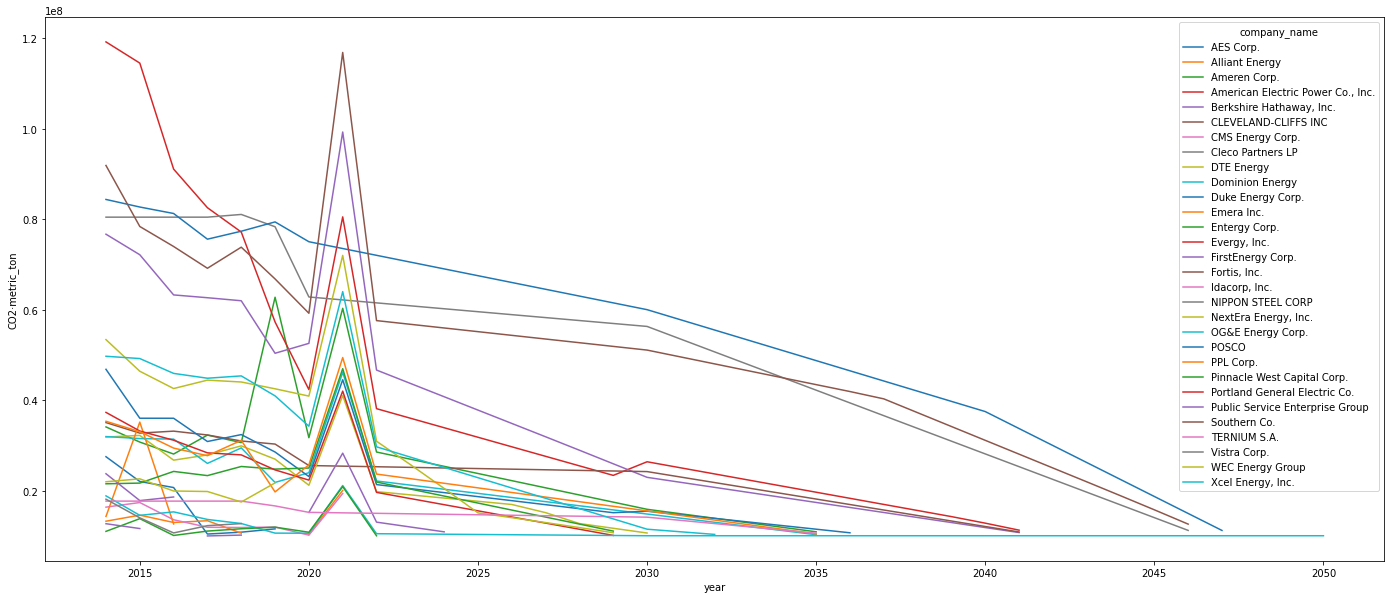

In [10]:
ureg.setup_matplotlib(True)
plottable_df = df.pivot(index='year', columns='company_name', values='co2_s1_by_year').reset_index()
# Must plot the first few columns, but then plot 1/3rd of the companies so as not to over-clutter the graph
plottable_df.plot(x='year', kind='line', figsize=(24,10))

## From this point forward, this is just a sketch...

While we could technically instantiate Quant and User engines and demonstrate the access restrictions particular to those personna, it's not really "right" to demonstrate restrictions via the database that can still be accessed via the python namespace.  So we actually put the following code into separate notebooks which cannot access the data in dataframes above.

### Step 4: Use Quant engine to access and visualize temperature scores

When the Data Vault is ready to be implemented, we can demonstrate that the Quant engine does not have access to primary company data (neither financial nor production)

Show that we *cannot* access fundamental company data (cannot show until op1st team changes permissions)

Show that we *can* access both cumulative emissions (input) and temperature scores (output)

### Step 5: Show per-company temperature score and weighted portfolio alignment score

Portfolio weighting scores (which ultimately influence portfolio alignment score) include:
* WATS (size of portfolio company positions used as weights)
* TETS (size of total emissions of portfolio companies used as weights)
* Financial fundamental weights:
    * Market Cap
    * Enterprise Value
    * Assets
    * Revenues

We can pass a list of company IDs to the Data Vault to get back a sum without exposing granular data

Show that we *cannot* access fundamental company data (cannot show until op1st team changes permissions)

Show that we *can* access both cumulative emissions (input) and temperature scores (output)

### Calculate portfolio alignment temperature score based on WATS

We can do this with information exclusive to the user space (and the probability-adjusted temperature scores)

Note that companies with no production information (such as TITAL INTERNATIONAL INC and UNIVERSAL STAINLESS & ALLOY PRODUCTS INC will show NaN (Not a Number) as a score.

### Calculate portfolio alignment temperature score based on TETS

We need to carefully meld portfolio data with corp fundamental data (in this case, emissions)

### Calculate portfolio alignment temperature score based on MOTS, EOTS, ECOTS, AOTS, and ROTS

* MOTS = market cap weights
* EOTS = enterprise value weights
* ECOTS = EVIC weights
* AOTS = asset weights
* ROTS = revenue weights

### Companies for which we lack production data (and thus cannot chart)